### импорты


In [ ]:
!pip install jira
!pip install pymorphy2

     |████████████████████████████████| 61kB 2.9MB/s 
     |████████████████████████████████| 61kB 4.5MB/s 
     |████████████████████████████████| 61kB 6.3MB/s 
     |████████████████████████████████| 3.2MB 7.8MB/s 
     |████████████████████████████████| 61kB 3.5MB/s 
     |████████████████████████████████| 8.2MB 4.6MB/s 


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

from jira import JIRA
import json
import ast
import pymorphy2

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10,10)

FILE_PATH = '/content/drive/MyDrive/Colab Notebooks/Korus/nlp_tasks/find_assignee/data/'


### Загрузить модель


In [ ]:
file_name = 'epoch_29_val_acc_0.80.hdf5'
model = tf.keras.models.load_model(FILE_PATH+file_name)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         5120000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 256)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 512)         1050624   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 512)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 512)         1574912   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dense (Dense)                (None, 512)               2

### Посмотреть данные, на которых обучалась модель

In [ ]:
#тренировочные данные
file_name = 'find_assignee_010620-260421_for_training.csv'
training_data = pd.read_csv(FILE_PATH+file_name, sep=';', index_col='issue_number')
training_data['full_text'] = training_data['full_text'].apply(ast.literal_eval)
training_data.head(5)

,source,from,subject,body,assignee,group,target_user,full_text
issue_number,,,,,,,,
HELPDESK-1301596,helpdesk@esphere.ru,metazon@ozon.ru,"ответ по заказу edi от юнилевер русь, ооо","поставщик юнилевер русь, ооо ответил по зака...",andreev.rv,edi,edi-hd,"[<SRC>, helpdesk@esphere.ru, <ATHR>, metazon@o..."
HELPDESK-1301579,jira@jiramail.esphere.ru,Elena.Aldaranova@guest.ferrero.com,загрузить recadv на,"татьяна, добрый день . просьба загрузить recad...",semenova.ts,edi,edi-hd,"[<SRC>, jira@jiramail.esphere.ru, <ATHR>, Elen..."
HELPDESK-1301548,helpdesk@esphere.ru,monitoring_bp@magnit.ru,exception . отсутствует статус доставки orders...,добрый день ! направляем вам отчет по edi доку...,naumov.ya,мониторинг,usc,"[<SRC>, helpdesk@esphere.ru, <ATHR>, monitorin..."
HELPDESK-1301547,ast223@esphere.ru,Yajzler.DA@esphere.ru,запрос закрывающего документа,"добрый день, ооо альфавэск номер счета п...",merezhkin.ds,bsr,uzedo-hd,"[<SRC>, ast223@esphere.ru, <ATHR>, Yajzler.DA@..."
HELPDESK-1301542,help@esphere.ru,ANikitina@esphere.ru,продление электронной подписи инн,"добрый день!подскажите пожалуйста, еум показыв...",merezhkin.ds,bsr,uzedo-hd,"[<SRC>, help@esphere.ru, <ATHR>, ANikitina@esp..."


In [ ]:
# # без предобработки
# file_name = 'find_assignee_010620-260421_validated.csv' 
# training_data = pd.read_csv(FILE_PATH+file_name, sep=';', index_col='issue_number')
# training_data.head(5)

,source,from,subject,body,assignee,group,target_user
issue_number,,,,,,,
HELPDESK-1301596,helpdesk@esphere.ru,metazon@ozon.ru,Ответ по заказу EDI [ 44761944 от 26.04.2021 ]...,"Поставщик ""Юнилевер Русь, ООО""\nОтветил по зак...",andreev.rv,edi,edi-hd
HELPDESK-1301579,jira@jiramail.esphere.ru,Elena.Aldaranova@guest.ferrero.com,Загрузить RECADV на AS2_Виктория,"Татьяна, добрый день.\r\n\r\nПросьба загрузить...",semenova.ts,edi,edi-hd
HELPDESK-1301548,helpdesk@esphere.ru,monitoring_bp@magnit.ru,Exception. Отсутствует статус доставки ORDERS ...,Добрый день!\r\n\r\nНаправляем Вам отчет по ED...,naumov.ya,мониторинг,usc
HELPDESK-1301547,ast223@esphere.ru,Yajzler.DA@esphere.ru,Запрос закрывающего документа,"Добрый день, \n \nООО «АльфаВЭСК» ИНН860320323...",merezhkin.ds,bsr,uzedo-hd
HELPDESK-1301542,help@esphere.ru,ANikitina@esphere.ru,Продление электронной подписи инн 501602893290,"Добрый день!Подскажите пожалуйста, ЕУМ показыв...",merezhkin.ds,bsr,uzedo-hd


### получить несколько запросов

In [2]:
import json


def read_json(file_path):
    with open(file_path, "r") as f:
        return json.load(f)


#читаю конфиг
cfg = read_json(FILE_PATH+"cfg.json")
jira_options = {'server': cfg['server']}
basic_auth=(cfg['username'], cfg['password'])

# Открываю сессию jira
jira = JIRA(options=jira_options, basic_auth=basic_auth)

In [ ]:
# Получаю батч запросов за июнь, которые были назначены Данилом.
JQL = 'project = HELPDESK AND created >= 2021-06-01 AND created <= 2021-07-01 AND status in (Решена, Закрыта) AND assignee changed from usc AND assignee changed by (Yajzler.DA) ORDER BY created DESC'
fields = 'creator, customfield_13590, summary, description, assignee, component'
helpdesk_issues = []
helpdesk_issues.extend(jira.search_issues(JQL, fields=fields, maxResults=10000))

print('выгржено запросов: %s' % len(helpdesk_issues))

выгржено запросов: 3000


In [ ]:
# Закрываю сессию Jira
jira.close()

In [ ]:
# Перевожу загруженные данные в датафрейм
issue_num = []
source = []
creator = []
subject	= []
body = []
assignee = []

for iss in helpdesk_issues:
  issue_num.append(iss.key)
  try:
    source.append(iss.fields.customfield_13590)
  except AttributeError:
    source.append(np.nan)
  creator.append(iss.fields.creator.emailAddress)
  subject.append(iss.fields.summary)
  body.append(iss.fields.description)
  try:
    assignee.append(iss.fields.assignee.key)
  except AttributeError:
    assignee.append(np.nan)

find_assignee = pd.DataFrame(
    {'source':source, 'from':creator, 'subject':subject, 'body':body, 'assignee':assignee},
    index=pd.Index(issue_num, name='issue_number'))
                             
find_assignee

,source,from,subject,body,assignee
issue_number,,,,,
HELPDESK-1359943,jira@jiramail.esphere.ru,kurtasova@bwf.ru,настройки адаптера и Сфера Курьер по документа...,"Партнеры, добрый день!\r\n\r\nВ связи с вступл...",pyanov.ai
HELPDESK-1359788,help@esphere.ru,edo@auchan.ru,Изменения в Справочнике Ашан (UC-ACT-GLN-ADDR)...,Добрый день!\r\nИзменения в справочнике.\r\n\r...,osina.nv
HELPDESK-1359743,help@esphere.ru,eklevtsova@ozon.ru,"ЛОбачевского, нет прав , ошибка","Добрый день, не получается подписать док-т в Э...",potatueva.aa
HELPDESK-1359670,ecod.hd@esphere.ru,interconnection@skbkontur.ru,Ошибка отправки документов в роуминг,"Добрый день!\r\n\r\nТС Зельгрос, ИНН 505005851...",izhik.ea
HELPDESK-1359666,helpdesk@esphere.ru,metazon@ozon.ru,Ответ по заказу EDI [ 45054151 от 30.06.2021 ]...,"Поставщик ""Торговый Дом ""Дмитрогорский продукт...",novikov.my
...,...,...,...,...,...
HELPDESK-1330465,jira@jiramail.esphere.ru,serenko-zakaz@yandex.ru,Без темы,Добрый день! Опять возникла проблема с МЕТРО. ...,kotelnikov.ea
HELPDESK-1330464,jira@jiramail.esphere.ru,ira.trifonova.89@mail.ru,"ООО ""Вельта-Пенза"" ИНН 5834053898",Добрый день! \nПрошу продублировать накладную ...,novikov.my
HELPDESK-1330455,Личное обращение,Kochkin.KV@esphere.ru,"Тестовые заказы по ТС Тандер/Х5 ООО ""НЕВИННОМЫ...",Прошу направить клиенту тестовые заказы по ТС ...,kornilov.ap


### Предобработка запросов

In [ ]:
# Создать словарь
def build_vocab(tokenized_texts, 
                max_words=20_000, 
                min_words_count=3, 
                add_tech_tokens=False):
    '''Умеет оставлять в словаре только max_words самых популярных слов. 
    min_words_count убирает редкие слова'''

    all_words = [word for tokens in tokenized_texts for word in tokens]
    vocab = {}
    for word in all_words:
      if word not in vocab:
        vocab[word] = 1
      else:
        vocab[word] += 1
    vocab = pd.DataFrame({'keys':vocab.keys(), 'values':vocab.values()})

    #Добавляю технические слова
    if isinstance(add_tech_tokens, (np.ndarray, list)):
      keys = add_tech_tokens
      values = list(range(999999,999999-len(add_tech_tokens), -1))
      special_words = pd.DataFrame({'keys':keys, 'values':values})
      vocab = pd.concat([vocab, special_words])
    elif add_tech_tokens == 'def':
      special_words = pd.DataFrame({'keys':["<PAD>", "<START>", "<UNKNOWN>"], 'values':[999999,999998,999997]})
      vocab = pd.concat([vocab, special_words])
    
    vocab.drop_duplicates(subset=['keys'], inplace=True, keep='last')
    print("%s words total, with max vocabulary size of %s" % (len(all_words), vocab.shape[0]))
    vocab = vocab[vocab['values'] >= min_words_count] \
      .sort_values(by='values', ascending=False) \
      .reset_index(drop=True).copy()
    # vocab.drop(columns='values', inplace=True)
    vocab = vocab[:max_words]
    print("Current vocabulary size is %s" % vocab.shape[0])

    vocab_idx_word_dict = vocab['keys'].to_dict()
    vocab_word_idx_dict = dict([(value, key) for (key, value) in vocab_idx_word_dict.items()])

    sentence_lengths = [len(tokens) for tokens in tokenized_texts]
    print("Max sentence length is %s" % max(sentence_lengths))
    return vocab, vocab_word_idx_dict, vocab_idx_word_dict

tokens = ['<PAD>', '<SRC>', '<ATHR>', '<SBJCT>', '<BODY>', '<END>', '<UNKNOWN>']
VOCAB, vocab_word_idx_dict, vocab_idx_word_dict = build_vocab(training_data.full_text.values, add_tech_tokens=tokens)

5998152 words total, with max vocabulary size of 83673
Current vocabulary size is 20000
Max sentence length is 3867


In [ ]:
# Кодировать целевой класс
label_enc = LabelEncoder()
training_data['class_label'] = label_enc.fit_transform(training_data.group)

labels = {}
for v, k in zip(label_enc.transform(label_enc.classes_), label_enc.classes_):
  print(v, k)
  labels[k] = v

0 bsr
1 eco
2 edi
3 edo
4 intgr
5 мониторинг
6 тандер


In [ ]:
# Вспомогательные функции

# Очистка текста
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"www\S+", "")
    df[text_field] = df[text_field].str.replace(r"\[\S+\]", " ") #вставки картинок или ссылок
    df[text_field] = df[text_field].str.replace(r"ё", "е")
    df[text_field] = df[text_field].str.replace(r"[^А-Яа-яA-Za-z0-9.,!?@\\\-\'\_\s]+", " ") #всё лишнее убираем
    df[text_field] = df[text_field].str.replace(r"[\w.,!?@\\\'\`\"\_\-]*[0-9@]+[\w.,!?@\'\`\"\_\-]*", " ") #всё что с цифрами или @ убираем
    df[text_field] = df[text_field].str.replace(r"([,.!?])[\s\t\n]", r" \1 ") #чтобы знаки препинания делились как отдельные слова
    df[text_field] = df[text_field].str.replace(r"([.!?\|\\\'\`\"\_]){2,}", r" \1 ") # убрать повторяющиеся символы
    df[text_field] = df[text_field].str.replace(r"\s+", " ")
    df[text_field] = df[text_field].str.replace(r"( \.){2,}", " .")
    df[text_field] = df[text_field].str.strip()
    return df

#Лемматизация русских слов
morph = pymorphy2.MorphAnalyzer()
def tokenize(text):
    words = text.split() # разбиваем текст на слова
    res = list()
    for word in words:
        p = morph.parse(word)[0]
        res.append(p.normal_form)
    return res

#нормальная форма
def normal_form(text):
    words = text.split() # разбиваем текст на слова
    res = list()
    for word in words:
        p = morph.parse(word)[0]
        res.append(p.normal_form)
    return ' '.join(res)


In [ ]:
# Объединяю source subject body в единый текст + лемматизация

standardized_subject = standardize_text(find_assignee, 'subject').subject.astype(str).apply(normal_form)
standardized_body = standardize_text(find_assignee, 'body').body.astype(str).apply(normal_form)

tokens = ['<PAD>', '<SRC>', '<ATHR>', '<SBJCT>', '<BODY>', '<END>', '<UNKNOWN>']
find_assignee['full_text'] = tokens[1] + ' ' + find_assignee['source'].astype(str) + ' ' \
  + tokens[2] + ' ' + find_assignee['from'].astype(str) + ' ' \
  + tokens[3] + ' ' + standardized_subject + ' ' \
  + tokens[4] + ' ' + standardized_body + ' ' \
  + tokens[5]
find_assignee['full_text'] = find_assignee['full_text'].str.split()

In [ ]:
# Кодировать текст
def encode_review(text, vocab_dict=vocab_word_idx_dict, pad=False):
    'text: pd.Series'
    idxs = [vocab_dict.get(word, vocab_dict['<UNKNOWN>']) for word in text]
    return idxs

def decode_review(encoded_text, vocab_dict=vocab_idx_word_dict):
    return ' '.join([vocab_dict.get(i, '?') for i in encoded_text])

find_assignee['encoded_text'] = find_assignee['full_text'].apply(encode_review)

In [ ]:
MAX_SEQ_LEN = 350

X = tf.keras.preprocessing.sequence.pad_sequences(
      find_assignee['encoded_text'].values,
      value=0,
      padding='post',
      maxlen=MAX_SEQ_LEN)


#### Как выглядят данные

In [ ]:
find_assignee
#всё целиком: и исходные данные и закодированные

,source,from,subject,body,assignee,full_text,encoded_text
issue_number,,,,,,,
HELPDESK-1359943,jira@jiramail.esphere.ru,kurtasova@bwf.ru,настройки адаптера и сфера курьер по документа...,"партнеры , добрый день ! в связи с вступлением...",pyanov.ai,"[<SRC>, jira@jiramail.esphere.ru, <ATHR>, kurt...","[1, 215, 2, 13908, 3, 204, 202, 11, 73, 118, 1..."
HELPDESK-1359788,help@esphere.ru,edo@auchan.ru,изменения в справочнике ашан uc-act-gln-addr,добрый день ! изменения в справочнике . вкладк...,osina.nv,"[<SRC>, help@esphere.ru, <ATHR>, edo@auchan.ru...","[1, 59, 2, 13133, 3, 315, 8, 1750, 400, 6, 4, ..."
HELPDESK-1359743,help@esphere.ru,eklevtsova@ozon.ru,"лобачевского , нет прав , ошибка","добрый день , не получается подписать док-т в ...",potatueva.aa,"[<SRC>, help@esphere.ru, <ATHR>, eklevtsova@oz...","[1, 59, 2, 6, 3, 6, 46, 190, 410, 46, 37, 4, 1..."
HELPDESK-1359670,ecod.hd@esphere.ru,interconnection@skbkontur.ru,ошибка отправки документов в роуминг,"добрый день ! тс зельгрос , инн поставщик ао в...",izhik.ea,"[<SRC>, ecod.hd@esphere.ru, <ATHR>, interconne...","[1, 1093, 2, 2827, 3, 37, 140, 20, 8, 715, 4, ..."
HELPDESK-1359666,helpdesk@esphere.ru,metazon@ozon.ru,ответ по заказу edi от торговый дом дмитрогорс...,"поставщик торговый дом дмитрогорский продукт ,...",novikov.my,"[<SRC>, helpdesk@esphere.ru, <ATHR>, metazon@o...","[1, 175, 2, 794, 3, 220, 10, 39, 61, 29, 227, ..."
...,...,...,...,...,...,...,...
HELPDESK-1330465,jira@jiramail.esphere.ru,serenko-zakaz@yandex.ru,без темы,добрый день ! опять возникла проблема с метро ...,kotelnikov.ea,"[<SRC>, jira@jiramail.esphere.ru, <ATHR>, sere...","[1, 215, 2, 15025, 3, 246, 266, 4, 18, 24, 15,..."
HELPDESK-1330464,jira@jiramail.esphere.ru,ira.trifonova.89@mail.ru,ооо вельта-пенза инн,добрый день ! прошу продублировать накладную в...,novikov.my,"[<SRC>, jira@jiramail.esphere.ru, <ATHR>, ira....","[1, 215, 2, 9622, 3, 16, 6, 38, 4, 18, 24, 15,..."
HELPDESK-1330455,Личное обращение,Kochkin.KV@esphere.ru,тестовые заказы по тс тандер ооо невинномысски...,прошу направить клиенту тестовые заказы по тс ...,kornilov.ap,"[<SRC>, Личное, обращение, <ATHR>, Kochkin.KV@...","[1, 211, 147, 2, 7546, 3, 609, 39, 10, 96, 213..."


### Вызвать инференс - предсказать класс

In [ ]:
%%time
# 10 запросов
predictions10 = model.predict(X[:10])

CPU times: user 1.99 s, sys: 213 ms, total: 2.2 s
Wall time: 1.25 s


In [ ]:
%%time
# 3000 запросов батчами по 64 запроса
predictions = []
for i in range(0,3000, 64):
  start = i
  end = i+64
  if end > 3000: end = 3000
  predictions.append(model.predict(X[start:end]))
predictions = np.vstack(predictions)

CPU times: user 8min 44s, sys: 25.6 s, total: 9min 10s
Wall time: 5min 1s


### Interpret predictions


In [ ]:
predicted_data = find_assignee.iloc[:, :5].copy()
predicted_data['predicted_group'] = label_enc.inverse_transform(np.argmax(predictions, axis=1))
predicted_data

,source,from,subject,body,assignee,predicted_group
issue_number,,,,,,
HELPDESK-1359943,jira@jiramail.esphere.ru,kurtasova@bwf.ru,настройки адаптера и сфера курьер по документа...,"партнеры , добрый день ! в связи с вступлением...",pyanov.ai,intgr
HELPDESK-1359788,help@esphere.ru,edo@auchan.ru,изменения в справочнике ашан uc-act-gln-addr,добрый день ! изменения в справочнике . вкладк...,osina.nv,edo
HELPDESK-1359743,help@esphere.ru,eklevtsova@ozon.ru,"лобачевского , нет прав , ошибка","добрый день , не получается подписать док-т в ...",potatueva.aa,eco
HELPDESK-1359670,ecod.hd@esphere.ru,interconnection@skbkontur.ru,ошибка отправки документов в роуминг,"добрый день ! тс зельгрос , инн поставщик ао в...",izhik.ea,edo
HELPDESK-1359666,helpdesk@esphere.ru,metazon@ozon.ru,ответ по заказу edi от торговый дом дмитрогорс...,"поставщик торговый дом дмитрогорский продукт ,...",novikov.my,edi
...,...,...,...,...,...,...
HELPDESK-1330465,jira@jiramail.esphere.ru,serenko-zakaz@yandex.ru,без темы,добрый день ! опять возникла проблема с метро ...,kotelnikov.ea,intgr
HELPDESK-1330464,jira@jiramail.esphere.ru,ira.trifonova.89@mail.ru,ооо вельта-пенза инн,добрый день ! прошу продублировать накладную в...,novikov.my,edi
HELPDESK-1330455,Личное обращение,Kochkin.KV@esphere.ru,тестовые заказы по тс тандер ооо невинномысски...,прошу направить клиенту тестовые заказы по тс ...,kornilov.ap,edi


In [ ]:
#@title Groups_by_assignee

# собираю датафрейм принадлежности пользователей к группам
def define_hd_groups():
  df_rnd_edi_group = pd.DataFrame(
    {'user':rnd_edi_group, 'group':'edi', 'target_user':'edi-hd'})
  df_rnd_edo_group = pd.DataFrame(
    {'user':rnd_edo_group, 'group':'edo', 'target_user':'edo-hd'})
  df_intgr_group = pd.DataFrame(
    {'user':intgr_group, 'group':'intgr', 'target_user':'int-hd'})
  df_eco_group = pd.DataFrame(
    {'user':eco_group, 'group':'eco', 'target_user':'usc'})
  df_bsr_group = pd.DataFrame(
    {'user':bsr_group, 'group':'bsr', 'target_user':'uzedo-hd'})
  # df_vet_group = pd.DataFrame(
  #   {'user':vet_group, 'group':'vet.hd', 'target_user':'НА РУЧНУЮ ОБРАБОТКУ'})
  df_monitoring = pd.DataFrame(
    {'user':monitoring, 'group':'мониторинг', 'target_user':'usc'})
  df_tander_group = pd.DataFrame(
    {'user':tander_group, 'group':'тандер', 'target_user':tander_group[0]})  
  df_irrelevant = pd.DataFrame(
    {'user':irrelevant, 'group':'Другие пользователи', 'target_user':'<НА РУЧНУЮ ОБРАБОТКУ>'})    

 
  hd_groups = pd.concat([df_rnd_edi_group, 
                         df_rnd_edo_group, 
                         df_intgr_group, 
                         df_eco_group, 
                         df_bsr_group, 
                        #  df_vet_group,
                         df_monitoring,
                         df_tander_group,
                         df_irrelevant,
                         ])
  return hd_groups

# _sSPB-RETAILDIS-DTP-OTP_GrSupEDI-Empl
rnd_edi_group =['abramov.av',
                'arefev.as',
                'chirkov.aa',
                'edi-hd',
                'ilchenko.ma',
                'korobejnikova.kd',
                # 'kudryavtsev.as',
                'mangashov.ao',
                'milovskij.da',
                'mustafaeva.vm',
                'osokin.sa',
                'semenova.ts',
                'smirnova.av',
                'titova.nal',
                'vasilev.ap',
                'kuznetsov.ev',
                'krasilnikov.dp',
                'novikov.my',
                'andreev.rv',
                'kornilov.ap',
                'dolgushin.zd',
                'kiselev.ae',
                'titova.na',
                'kudryavtsev.as'
                ]

# _sSPB-RETAILDIS-DTP-OTP_GrSupUZDO-Empl
rnd_edo_group =['alekseev.na',
                'arkanova.iy',
                'edo-hd',
                'eskina.ms',
                'izhik.ea',
                'kosareva.ma',
                # 'kudryavtsev.as',
                'kuznecov.va',
                'manko.yd',
                'mikhajlov.pa',
                'oreshkina.ki',
                'sigitov.ig',
                'usov.di',
                'vereshhagin.na']

# _sSPB-RETAILDIS-DTP-OTP_GrSupIntgrProd-Empl
intgr_group =  ['bikmametov.mm',
                'buslaev.vi',
                'chistyakova.na',
                'dudkina.ae',
                'gajnetdinov.mr',
                'gogolev.ia',
                'goryunova.yg',
                'kanushina.vs',
                'konotopkin.da',
                'kotelnikov.ea',
                'lakhvostov.aa',
                'lysenkov.rv',
                'pikalova.yi',
                'pyanov.ai',
                'sarychev.av',
                'serbov.nn',
                'sokolov.aa',
                'terziyan.ds',
                'vladimirova.as',
                'zajtseva.ya',
                'fshareyko',
                'shulgin.aa',
                'apusenko',
                'int-hd']

# _sSPB-RETAILDIS-DTP-OTP_EdnCntrObsl-Empl
eco_group =    ['buslovskaya.em',
                'gondareva.dp',
                'grotskaya.ea',
                'khorkin.an',
                'kobzar.mv',
                'krasovskaya.vi',
                'mikhaleva.ea',
                'mindrik.av',
                'osina.nv',
                'potatueva.aa',
                'pozdeeva.ts',
                'romanenkova.oa',
                'valieva.er',
                'vorogushina.ni',
                'yajzler.da',
                'usc']


#тп бср
bsr_group =    ['fedorov.aa',
                'ifandeeva',
                'tokarev.ayu',
                'semenova.ma',
                'pulinets.es',
                'paskal.nk',
                'miroshnik.do',
                'merezhkin.ds',
                'kolomzarova.ma',
                'vedeneeva.en',
                'burykina.ea',
                'pavlov.aa',
                'polyakov.ra',
                'fedosenko.na',
                'mvoeykova',
                'jira.it67929.user',
                'sushilov.rs',
                'mbogatireva',
                'bogolepov.av',
                'aleksandrov.ns',
                'fefelov.es', # по какой-то причине он решает бсрные запросы
                'jira.it75167.user',
                'uzedo-hd']

# vet_group =    []

monitoring =   ['zhukov.ev',
                'dorofeev.na',
                'naumov.ya',
                'rudakov.ae',
                'tynkasova.ap',
                'satarov.rg',
                'pryazhnikov.vs',
                'garagennko.sv',
                'alimpiev.kv',
                'ihramov',
                'batura.an',
                'ivanchin.va'
                ]

tander_group = ['glavinskiy.aa']

#пользователи других проектов
irrelevant =   ['lagafonova',
                'lloginov',
                'myasnikov.fv',
                'iivanov',
                'koshkina.am',
                'rusakov.ps',
                'vet.hd',
                'yakubovskij.ml', 'pankov.av', 'ostanina.ay', 'gladysheva.es',
                'elshina.nk', 'vladimirov.s', 'ustyantseva.os', 'shafikova.ayu',
                'pysina.kv', 'popova.ym', 'mmikhaylova', 'melnikova.oa',
                'filichev.ss', 'arzumanova.nk'
                ]

hd_groups = define_hd_groups()

In [ ]:
predicted_data_amplified = predicted_data.merge(hd_groups, how='left', left_on='assignee', right_on='user', ).rename(columns={'group':'group_by_assignee'})
predicted_data_amplified.drop(columns=['user', 'target_user'], inplace=True)
predicted_data_amplified.dropna(subset=['group_by_assignee'], inplace=True)
y_pred = label_enc.transform(predicted_data_amplified.predicted_group.values)
y_true = label_enc.transform(predicted_data_amplified.group_by_assignee.values)
predicted_data_amplified

,source,from,subject,body,assignee,predicted_group,group_by_assignee
0,jira@jiramail.esphere.ru,kurtasova@bwf.ru,настройки адаптера и сфера курьер по документа...,"партнеры , добрый день ! в связи с вступлением...",pyanov.ai,intgr,intgr
1,help@esphere.ru,edo@auchan.ru,изменения в справочнике ашан uc-act-gln-addr,добрый день ! изменения в справочнике . вкладк...,osina.nv,edo,eco
2,help@esphere.ru,eklevtsova@ozon.ru,"лобачевского , нет прав , ошибка","добрый день , не получается подписать док-т в ...",potatueva.aa,eco,eco
3,ecod.hd@esphere.ru,interconnection@skbkontur.ru,ошибка отправки документов в роуминг,"добрый день ! тс зельгрос , инн поставщик ао в...",izhik.ea,edo,edo
4,helpdesk@esphere.ru,metazon@ozon.ru,ответ по заказу edi от торговый дом дмитрогорс...,"поставщик торговый дом дмитрогорский продукт ,...",novikov.my,edi,edi
...,...,...,...,...,...,...,...
2995,jira@jiramail.esphere.ru,serenko-zakaz@yandex.ru,без темы,добрый день ! опять возникла проблема с метро ...,kotelnikov.ea,intgr,intgr
2996,jira@jiramail.esphere.ru,ira.trifonova.89@mail.ru,ооо вельта-пенза инн,добрый день ! прошу продублировать накладную в...,novikov.my,edi,edi
2997,Личное обращение,Kochkin.KV@esphere.ru,тестовые заказы по тс тандер ооо невинномысски...,прошу направить клиенту тестовые заказы по тс ...,kornilov.ap,edi,edi
2998,helpdesk@esphere.ru,Roman.Mikheev@pepsico.com,заказ от клиента яндекс.лавка,"уважаемые партеры , добрый день ! уточните пож...",ilchenko.ma,edi,edi


### eval metrics

accuracy score 0.700


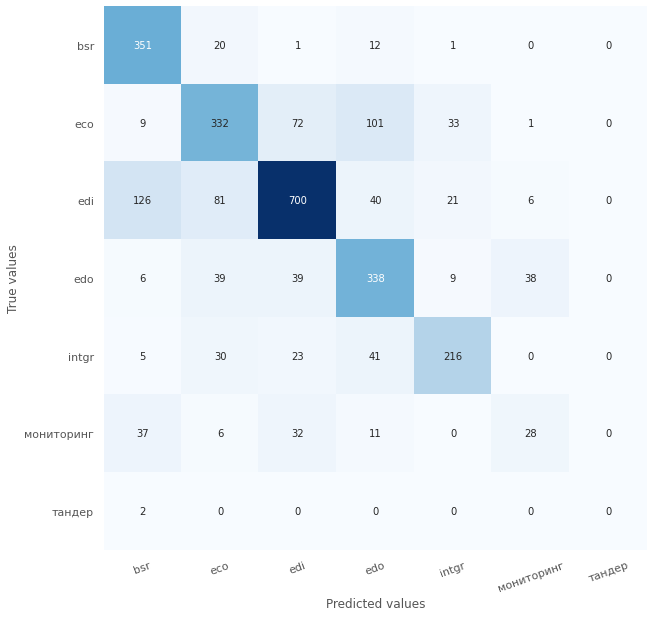

In [ ]:
print('accuracy score %.3f' % accuracy_score(y_true, y_pred))
plt.figure(figsize=(10, 10))
ax = sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap="Blues", cbar=False, square=True, fmt="d")
ax.set_xticklabels(labels.keys(), rotation=20)
ax.set_yticklabels(labels.keys(), rotation=0)
ax.set_xlabel('Predicted values')
ax.set_ylabel('True values');